# Importing Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import *

import pymongo

from pyspark.ml.feature import Tokenizer,StopWordsRemover
from PIL import Image
import requests
from io import BytesIO


import re
import numpy as np
from pandas import DataFrame
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
# from os import getcwd
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt


# Initialising Spark Session and MongoDB Cluster Connection

In [3]:
client = pymongo.MongoClient("MongoDB Collection URL Here") # Collection URL Not specified for Data Security
db = client['steam_data']

spark = SparkSession.builder \
      .appName("Word count") \
      .getOrCreate()

# Text Cleaner Functions

In [4]:
def removePattern(inputText, pattern):
    r = re.findall(pattern, inputText)
    for i in r:
        inputText = re.sub(i, '', inputText)        
    return inputText

def getcleanTextText(filteredGameText):
    return ' '.join(filteredGameText)

def getSentimentScore(GameText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(GameText)
    return float(vs['compound'])

def getSentiment(score):
    return 1 if score > 0 else 0

# WordCloud Maker Function

In [14]:
def wordcloud_maker(spark,db,game_id,savepath):
    try:
            asd=db.game_data.find({"url_info.id":game_id },{'full_desc.desc':1,'img_url':1});
            asd=[i for i in asd]
            text=asd[0]['full_desc']['desc'].split('.')
            urll=asd[0]['img_url']
    except:
        return(False)
    df = DataFrame (text,columns=['string_list'])
    df = spark.createDataFrame(df)
    tokenizer = Tokenizer(inputCol='string_list', outputCol='words')
    dfcleanTextTokenized = tokenizer.transform(df)
    remover = StopWordsRemover(inputCol='words', outputCol='filteredGameText')
    dfStopwordRemoved=remover.transform(dfcleanTextTokenized)
    udfcleanTextText = udf(getcleanTextText, StringType())
    dfFilteredCleanedGame = dfStopwordRemoved.withColumn('filteredCleanedGameText', udfcleanTextText('filteredGameText'))
    udfSentimentScore = udf(getSentimentScore, FloatType())
    udfSentiment = udf(getSentiment, IntegerType())
    dfSentimentScore = dfFilteredCleanedGame.withColumn('sentimentScore', udfSentimentScore('filteredCleanedGameText'))
    dfSentiment = dfSentimentScore.withColumn('sentiment', udfSentiment('sentimentScore'))
    filteredCleanedGameTextRddList = dfSentiment.select('filteredCleanedGameText').collect()
    filteredCleanedGameTextList = [row.filteredCleanedGameText for row in filteredCleanedGameTextRddList]
    wordList = []
    for filteredCleanedGameText in filteredCleanedGameTextList:
         wordList.append(filteredCleanedGameText.split(' '))
    allGameWords = [word for subList in wordList for word in subList]
    allGameWords = list(filter(None, allGameWords))
    allGameWords=set(allGameWords)
    print(allGameWords)
    frequencyDistribution = nltk.FreqDist(allGameWords)
    response = requests.get(urll)
    alice_coloring = np.array((Image.open(BytesIO(response.content))))
    wc = WordCloud(mode='RGBA',mask=alice_coloring).generate_from_frequencies(frequencyDistribution)
    print(frequencyDistribution)
    image_colors = ImageColorGenerator(alice_coloring)
    wc.recolor(color_func=image_colors)
    print(type(wc))
    wc.to_file(savepath)
    plt.figure(figsize=(100,(100+50)))
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis('off')
    plt.show()
    return [allGameWords, frequencyDistribution]

# Final Step
    - Making WordCloud, Displaying it and saving it in specified path

{'guys:', 'failure', 'game', 'cooperative', 'couture', 'fellow', 'stumble', 'courses', 'shift', 'prepare', 'advancing', 'cooperative:', 'way', 'unbending', 'cut', 'towards', 'masses', 'online,', 'online', 'ridiculous', 'knockout', 'get', 'hopes', 'eliminated!comically', 'series', 'chaos', 'mad', 'dash', 'challenges', 'leave', 'bend,', 'physics', 'fail', 'physical:', 'crown!massive', 'contestants', 'wild', '&', 'competitors,', 'hilarious,', 'watch', 'free-for-alls', 'hordes', 'victor', 'flings', 'everything', 'customizable:', 'quest', 'competitors', 'next', 'obstacle', 'bizarre', 'fashionable', 'battle', 'competitive', 'physics-based', 'dignity', 'hilarious', 'claim', 'door', 'customize', 'available', 'mayhem', 'laws', 'obstacles,', 'overcome', 'remains!', 'pineapple', 'failure!delightfully', 'guys', 'fall', 'style', 'shove', 'escalating', 'hats', 'ultimate', 'delight', 'round', 'team', 'greatness', 'losing', 'bounce,', 'one', 'together', 'latest', 'bash', 'making', 'bunny', 'look', 'un

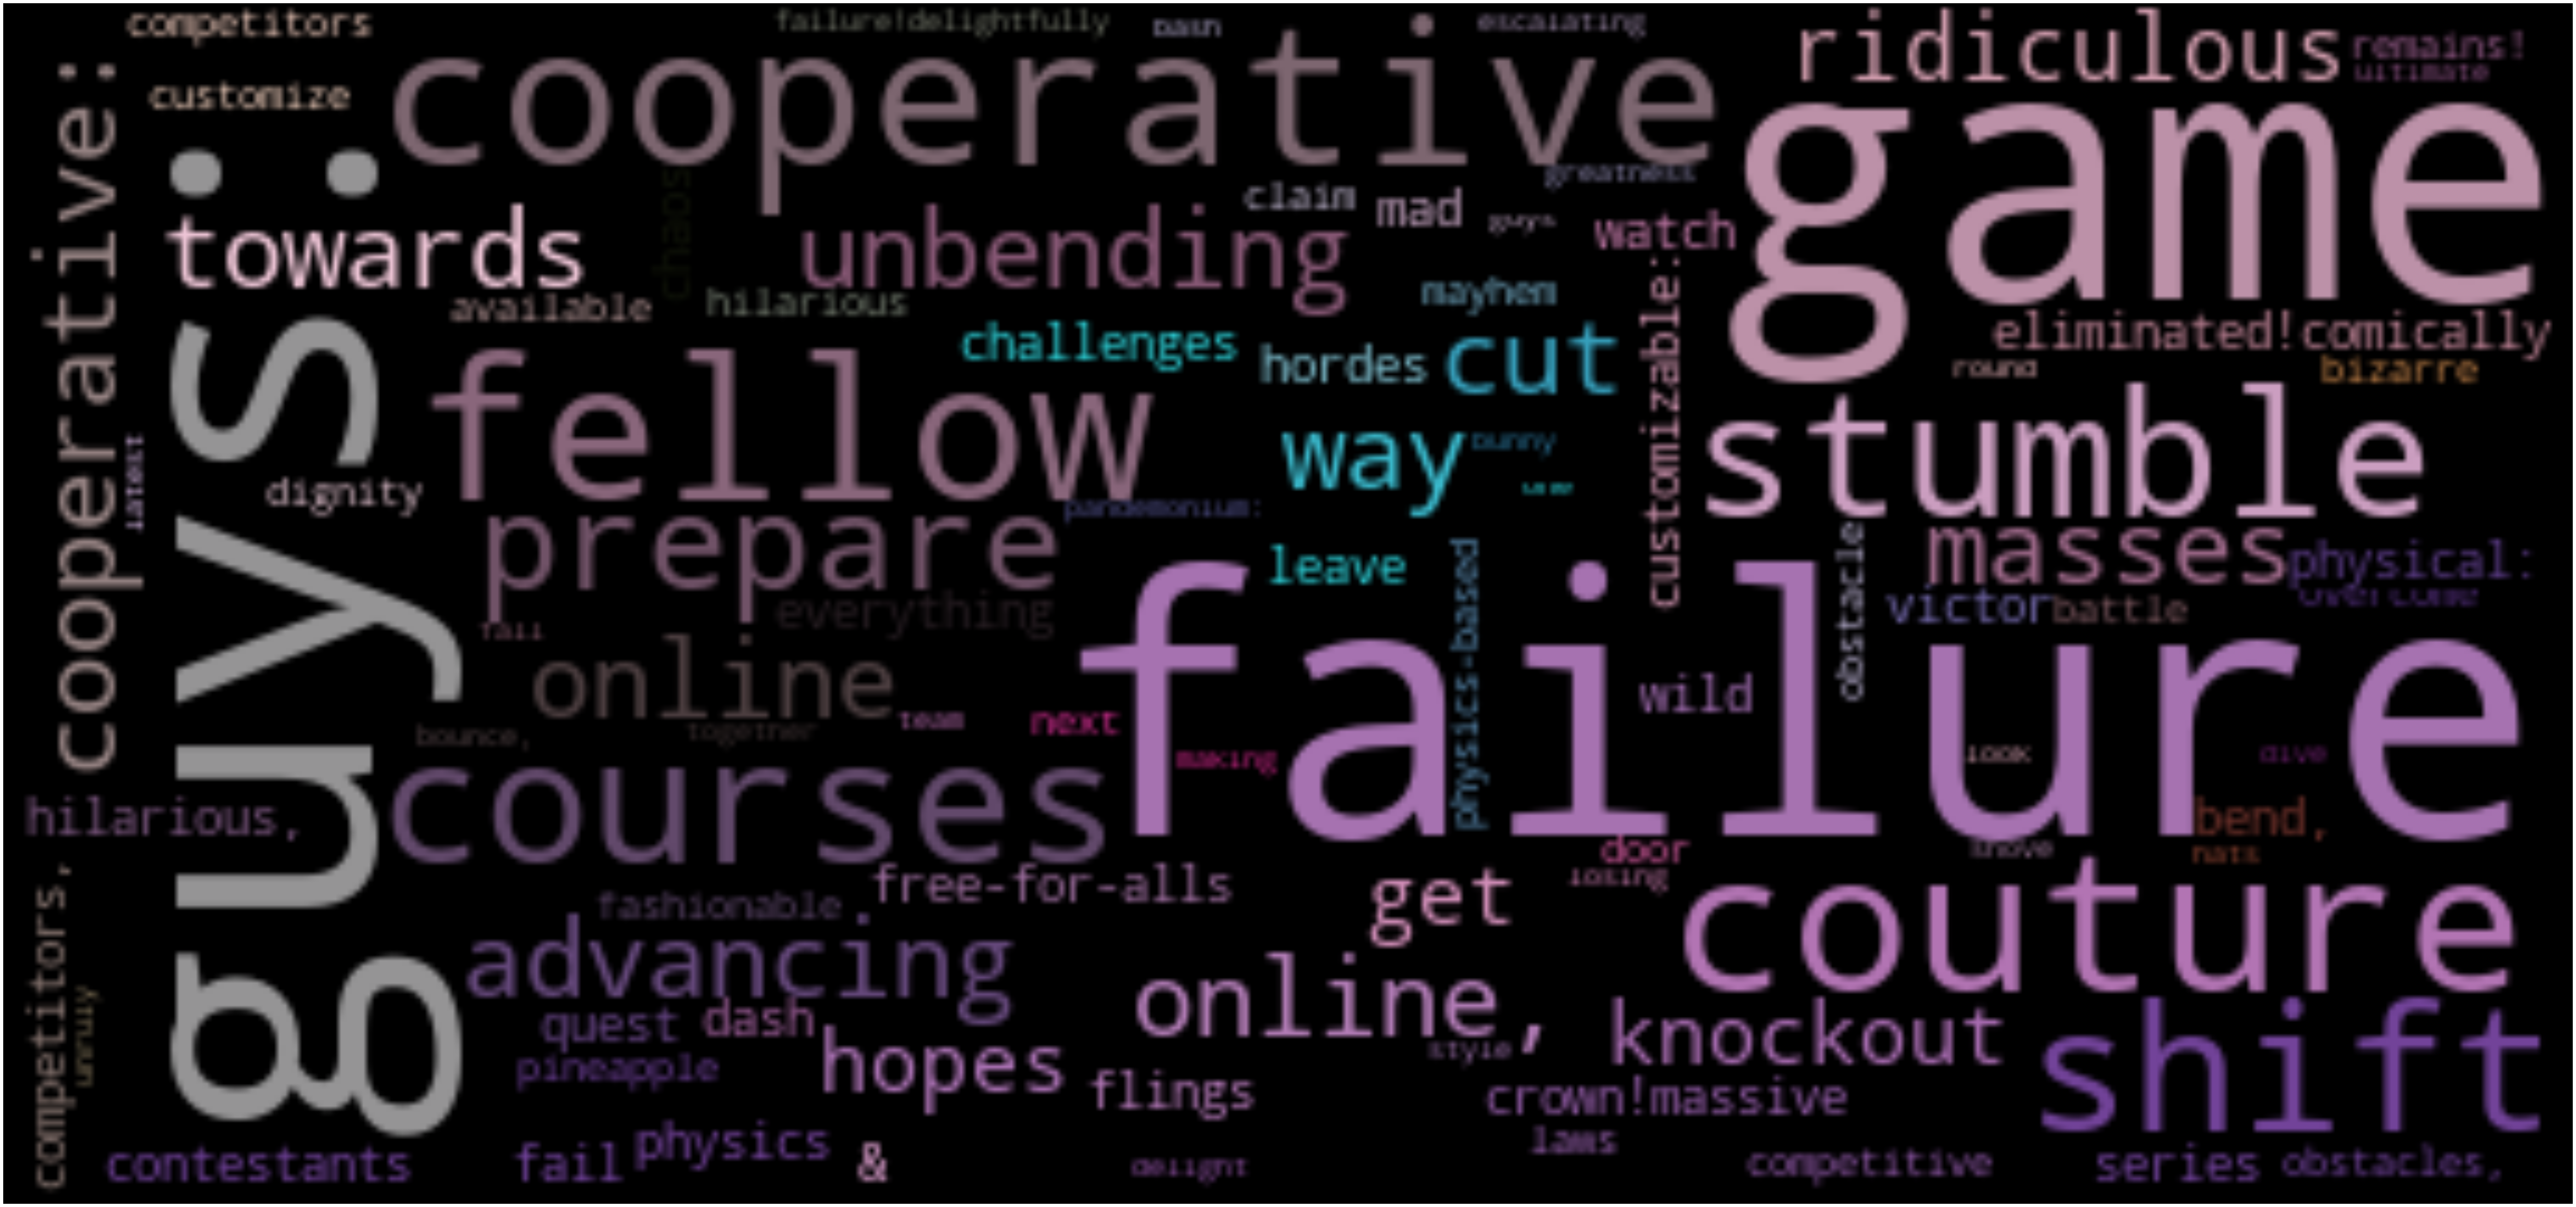

In [15]:
game_id='1097150' # sample game id given here, refer steam website for appropriate game id
asd=wordcloud_maker(spark,db,game_id,r"wdcld.png")